# (16) svhn — tst

**Motivation**: host = ```any```, device = ```cuda:2``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 2
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:2  ———  host: mach

In [36]:
model_name = 'poisson_SVHN_t-8_z-[512]_<jacob|mlp>'
fit_name = 'b200-ep350-lr(0.002)_beta(4:0x0.1)_temp(0.05:lin-0.5)_gr(100)_(2024_09_16,23:17)'

tr, meta = load_model(model_name=model_name, fit_name=fit_name, device=device, checkpoint=-1)
meta['checkpoint']

200

In [37]:
print(tr.model.layer.n_exp)

tensor([13, 21, 25, 30, 33, 35, 37, 37], device='cuda:2', dtype=torch.int32)

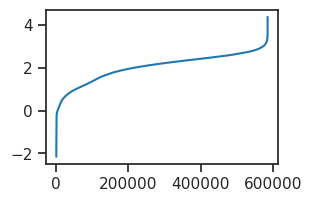

In [38]:
plt.plot(sorted(tr.model.stats['u_max']))

In [39]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

u_max[u_max > 5], du_max[du_max > 6]

(array([], dtype=float64), array([], dtype=float64))

In [40]:
u_max.max(), du_max.max()

(4.397063255310059, 3.9999990463256836)

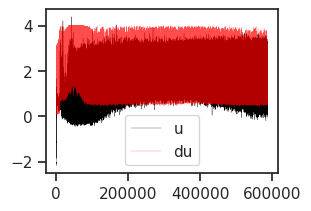

In [41]:
u_max = np.array(tr.model.stats['u_max'])
du_max = np.array(tr.model.stats['du_max'])

fig, ax = create_figure()
ax.plot(u_max, color='k', label='u', lw=0.2)
ax.plot(du_max, color='r', label='du', alpha=0.7, lw=0.2)
ax.legend()
plt.show()

100%|███████████████████████████████████| 2/2 [00:13<00:00,  6.94s/it]


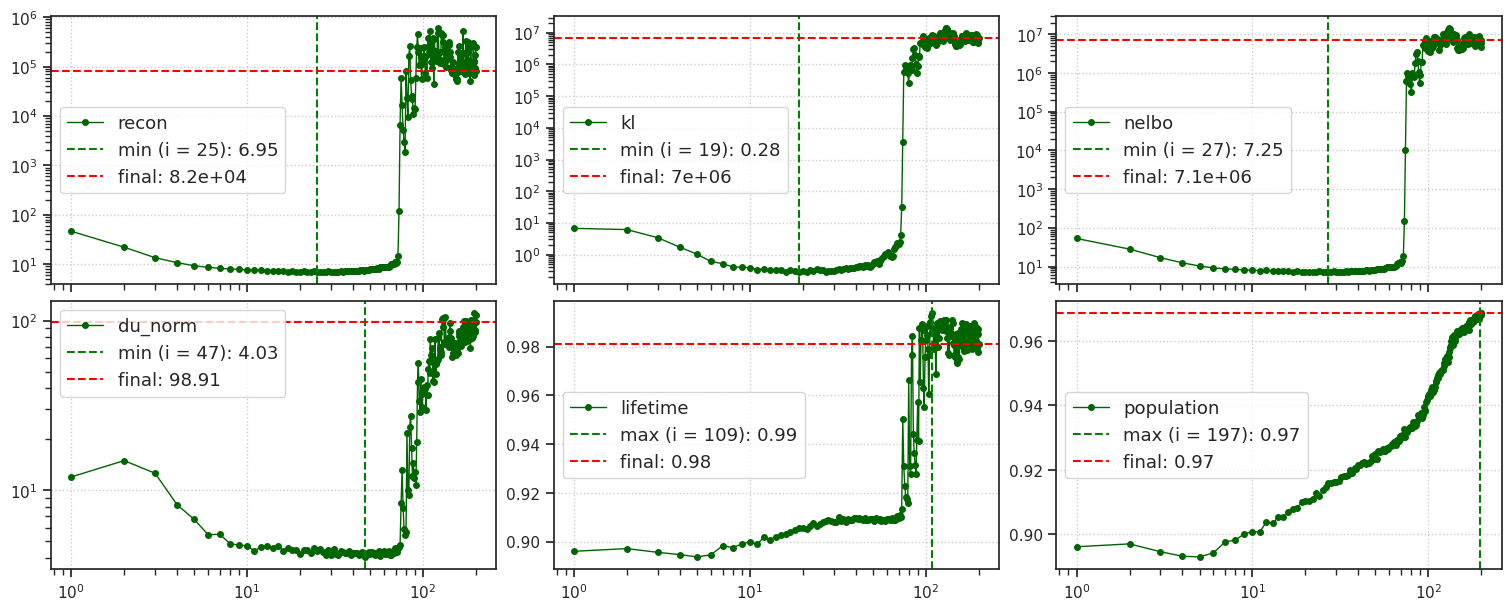

CPU times: user 15.8 s, sys: 120 ms, total: 15.9 s
Wall time: 16 s


In [42]:
%%time

kws = dict(
    seq_total=200,
    seq_batch_sz=100,
    n_data_batches=2,
    # active=~dead,
    # full_data=True,
    # return_recon=True,
)
results = tr.analysis(dl='vld', **kws)
_ = plot_convergence(results, color='darkgreen')

In [32]:
kws = dict(
    seq_total=tr.model.cfg.seq_len,
    seq_batch_sz=100,
    n_data_batches=1,
    # active=~dead,
    return_recon=True,
    full_data=True,
    verbose=False,
)
results_to_plot = {
    name: tr.analysis(dl=name, **kws)
    for name in ['trn', 'vld']
}

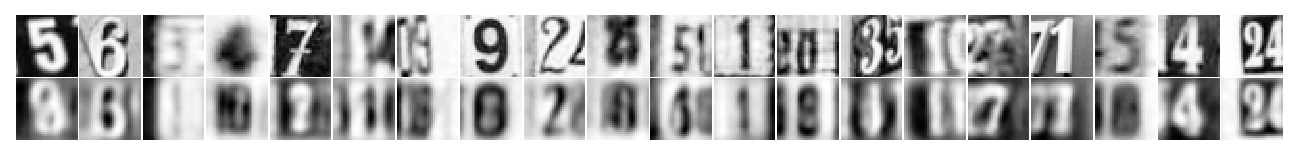

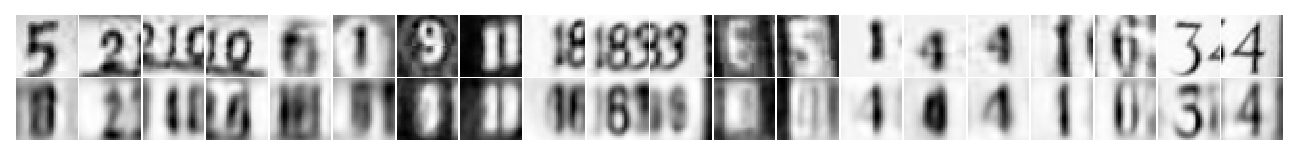

In [33]:
num = 20

x2p_dict = {}
for name, d in results_to_plot.items():
    x2p = np.concatenate([
        d['x'][:num],
        d['y'][:num, -1].reshape(-1, *tr.model.cfg.input_sz),
    ])
    _ = plot_weights(x2p, nrows=2)

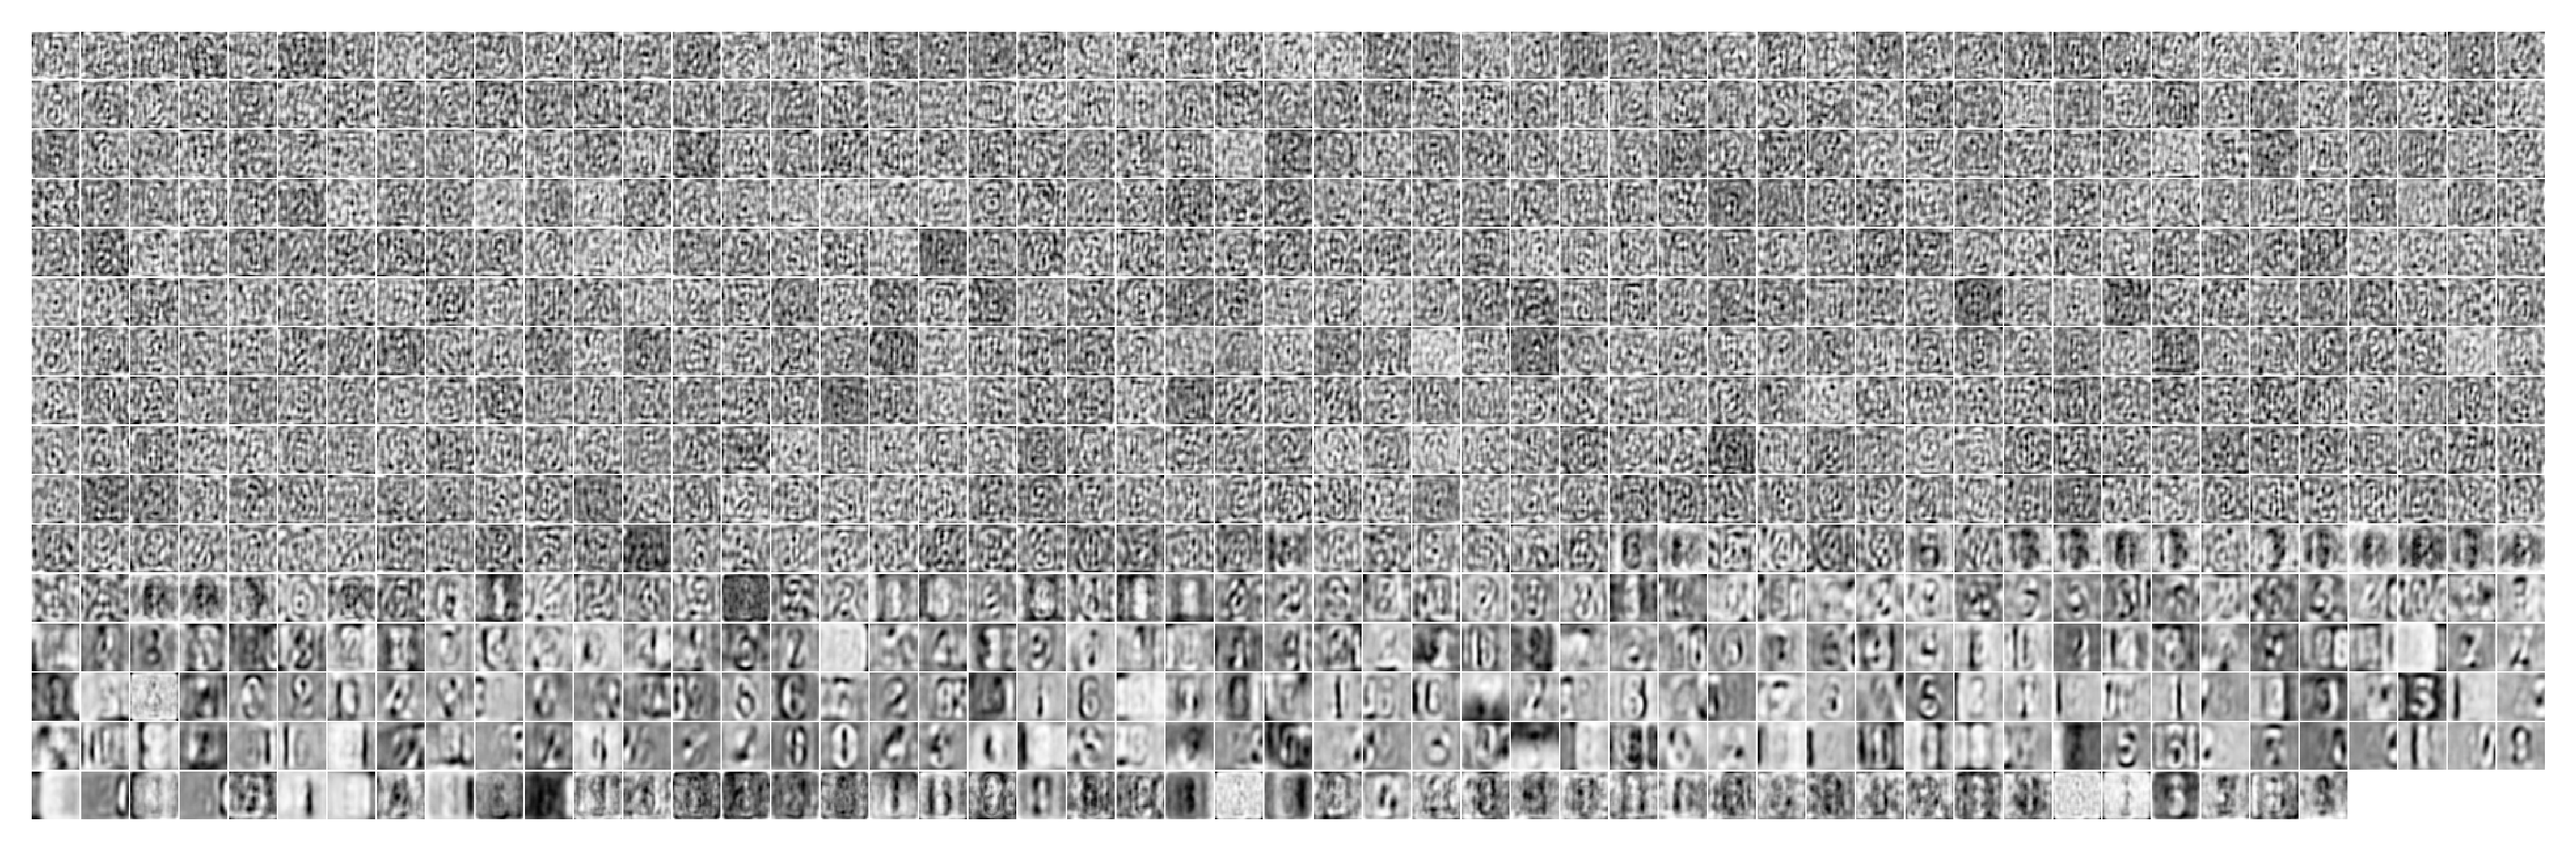

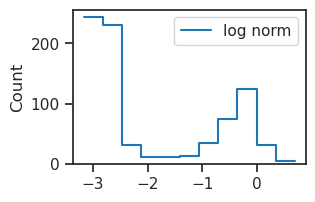

In [34]:
w = tr.model.layer.get_weight()
norms = tonp(torch.linalg.vector_norm(w, dim=1))

fig, ax = tr.model.show(order=np.argsort(norms), dpi=500)
fig.savefig(pjoin(fig_base_dir, f'mlp-MNIST-poisson-{name}.pdf'), bbox_inches='tight')

histplot(np.log(norms), label='log norm')
plt.legend()
plt.show()

NameError: name 'dead' is not defined

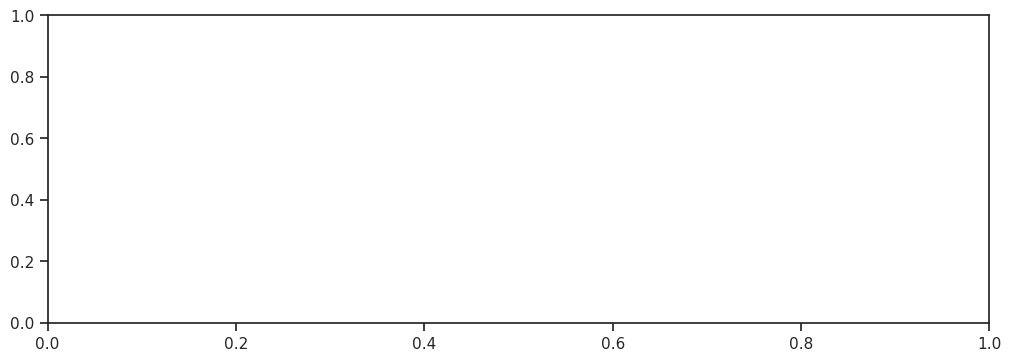

In [14]:
posterior_log_rates = collections.defaultdict(list)
for x, *_ in iter(tr.dl_vld):
    output = tr.model.xtract_ftr(x)
    for t, pois in output['dist'].items():
        posterior_log_rates[t].append(torch.log(pois.rate))
posterior_log_rates = {
    t: tonp(torch.cat(v)) for t, v
    in posterior_log_rates.items()
}


fig, ax = create_figure(1, 1, (10, 3.5))
pal = get_cubehelix_palette(tr.model.cfg.seq_len, start=2.5)

for i, (t, v) in enumerate(posterior_log_rates.items()):
    sns.histplot(
        v[:, ~dead].ravel(),
        stat='percent',
        element='step',
        fill=False,
        color=pal[i],
        label=f"T = {t}",
        ax=ax,
    )
# ax.legend()
ax.grid()
plt.show()


fig, axes = create_figure(2, 1, (6, 4.2), sharex='col')
for i, (t, v) in enumerate(posterior_log_rates.items()):
    for ax in axes.flat:
        sns.histplot(
            np.exp(v[:, ~dead].ravel()),
            stat='percent',
            element='step',
            fill=False,
            color=pal[i],
            label=f"T = {t}",
            ax=ax,
        )
axes[1].set(yscale='log')
add_grid(axes)
plt.show()